In [56]:
%matplotlib inline
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.stats import norm

pd.options.display.mpl_style = 'default'

In [3]:
# Get to the right working dir
os.chdir('C:\Users\Lewis\Documents\GitHub\dqn4wirelesscontrol')

In [12]:
# Detour: Generate a small sample file for testing purpose
sampleFile = open('./data/net_traffic_nonull_sample.dat', 'wb')
with open('./data/net_traffic_nonull.dat', 'rb') as trafficFile:
    trafficReader = csv.reader(trafficFile, delimiter=',')
    LIMIT = 1000
    cnt = 0
    for line in trafficReader:
        cnt += 1
        if cnt > LIMIT:
            break
        else:
            sampleFile.write(','.join(line)+'\n')        
sampleFile.close()

In [4]:
# Extract data from file and save into pd.DataFrame
session_df = pd.read_csv(filepath_or_buffer='./data/net_traffic_nonull_sample.dat', sep=',',
                        names=['uid','location','startT','duration','provider','type','domain','bytes','requests'])
session_df.index.name = 'sessionID'

In [5]:
# Convert column formats
session_df['startT'] = pd.to_datetime(session_df['startT'], unit='ms')  # convert start time to readible date_time strings
session_df['duration'] = session_df['duration']/1000.0  # convert duration unit to seconds
session_df['totalBytes'] = session_df['bytes'].apply(lambda x: x.split(';')).map(lambda x: sum(map(float, x)))  # sum bytes across domains
session_df['totalRequest'] = session_df['requests'].apply(lambda x: x.split(';')).map(lambda x: sum(map(float, x)))  # sum requests across domains

In [ ]:
# Aggregate by LocName and see total duration, bytes, and requests
grouped_session_df = session_df[['location','duration', 'totalBytes', 'totalRequest']].groupby(['location'])

Emperical Distributions:


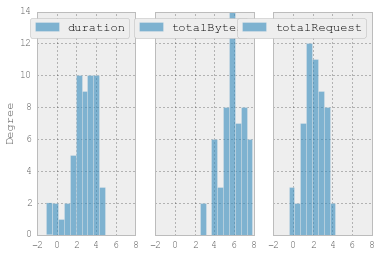

In [141]:
# Visulize emperical distribution (after log) from hist curve
print "Emperical Distributions:"
plt.figure()
sumByLocation = grouped_session_df.sum()
ax = np.log10(sumByLocation).plot(kind='hist', alpha=0.6, bins=15, subplots=True, layout=(1,3), sharex=True, sharey=True)
plt.show()
# ! Varies several OoM ( 6 for duration, 5 for totalBytes, 4 for totalRequests)
# Visualize the rank-size ditribution

Rank-Size Distributions:
Index([u'第三食堂', u'东上院', u'东下院', u'第二食堂', u'东中院二区', u'媒体与设计实验室B楼',
       u'农学生物学院-附楼三', u'null', u'农学生物学院-附楼二', u'新体育馆-近沧源路', u'菁菁堂', u'学生宿舍W',
       u'工程力学实验中心', u'第一食堂', u'文选医学楼', u'外语楼', u'学生宿舍D', u'陈瑞球北楼', u'逸夫科技楼',
       u'徐汇新上院', u'学生服务中心', u'伍威权堂', u'东中院四区', u'棒球场', u'陈瑞球楼', u'东中院一区',
       u'徐汇体育馆', u'第四食堂', u'校医院北楼', u'建筑馆', u'农学生物学院-附楼一', u'材料A楼', u'药学楼4号楼',
       u'老行政楼', u'东中院三区', u'学生宿舍X', u'药学楼1号楼', u'校医院南楼', u'电信群楼1号楼',
       u'分析测试中心1号楼', u'学生宿舍', u'西南体育馆-南体', u'程及美术馆', u'西中院', u'图书馆四区', u'西下院',
       u'分析测试中心2号楼', u'凯旋门-待定', u'学生事务中心-铁生馆', u'机械与动力工程学院', u'媒体与设计实验室A楼',
       u'光彪楼', u'包玉刚图书馆', u'基建处'],
      dtype='object', name=u'location')
Index([u'第三食堂', u'东下院', u'第二食堂', u'媒体与设计实验室B楼', u'东上院', u'东中院二区',
       u'农学生物学院-附楼三', u'null', u'第一食堂', u'菁菁堂', u'农学生物学院-附楼二', u'文选医学楼',
       u'陈瑞球楼', u'工程力学实验中心', u'外语楼', u'学生宿舍W', u'陈瑞球北楼', u'新体育馆-近沧源路', u'材料A楼',
       u'学生宿舍D', u'徐汇新上院', u'东中院四区', u'分析测试中心1号楼', u'学生服务中心', u'伍威权堂',
       u'农学生

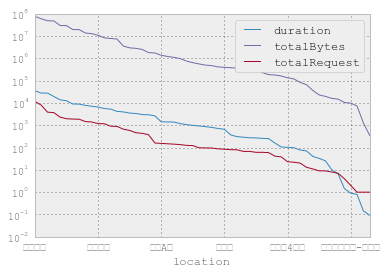

In [150]:
print "Rank-Size Distributions:"
plt.figure()
for i, index in enumerate(['duration', 'totalBytes', 'totalRequest']):
#     plt.subplot(1,3,i+1)
    sorted_copy = sumByLocation[index].copy()
    sorted_copy.sort(ascending=False)
    ax = sorted_copy.plot(x=pd.Series(range(len(sorted_copy.index))),logy=True)
    ax.set_ylim([10**(-2), 10**8])
    print sorted_copy.index
ax.legend(['duration', 'totalBytes', 'totalRequest'])
plt.show()
# ! Q: Follows to Zipf's law？ A: no, Zipf's is a straight line in log-log plot, here is a curvy curve
# ! Looks more like a exponential distribution with super-exp tail

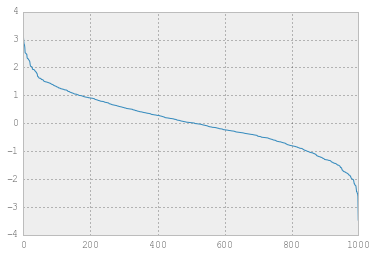

In [163]:
# Detour：What is the ranked plot of a series of normally distributed rvs
norm_sample = pd.Series(data=norm.rvs(size=1000), index=np.arange(1000))
norm_sample.sort(ascending=False)
norm_sample.index = np.arange(1000)
# norm_sample.head()
norm_sample.plot(y=norm_sample.data)
# plt.show()
# side-ways-S shape, not a straight line

In [235]:
# Session stats, e.g. inter-arrival time, session length
sorted_session_df = session_df.copy()  # get a copy to mess around
sorted_session_df.sort(['startT'], ascending=True, inplace=True)  # get it sorted
g_s_session_df = sorted_session_df.groupby('location')  # groupBy location
sorted_session_df['interArrival'] = g_s_session_df['startT'].diff()  # group-wise diff
des_by_location = sorted_session_df[['location','interArrival','duration']].groupby('location').describe()  # timedelta currently not support groupby aggregate
# des_by_location
des_by_location_swap = des_by_location.swaplevel(0,1)
des_by_location_swap.loc['mean']
# des_by_location_swap.index

# des_by_location.index
# print sorted_session_df[['location', 'interArrival']]

,duration,interArrival
location,,
null,238.533757,3 days 10:41:52.858472
东上院,327.474417,1 days 08:23:51.314469
东下院,379.958028,1 days 15:15:19.187633
东中院一区,109.091889,13 days 08:47:37.976375
东中院三区,16.024882,7 days 05:53:10.377687
东中院二区,257.531509,2 days 03:41:23.193250
东中院四区,154.009889,8 days 21:55:29.805375
伍威权堂,116.534167,8 days 19:59:38.566727
光彪楼,0.198500,24 days 00:21:40.012333
